# Multi-Annotator Consensus and Inter-Annotator Agreement (IAA) Analysis

## Purpose
This notebook processes annotations from 4 annotators (2 cybersecurity experts, 2 students) and:
1. Computes Inter-Annotator Agreement (IAA) metrics
2. Applies weighted voting to resolve disagreements
3. Flags cases requiring chief annotator adjudication
4. Generates final consensus labels for model training

## Taxonomy (5 Classes)
- **Class 0**: Legitimate
- **Class 1**: Commercial/R18 (medications, marketing, R18 content)
- **Class 2**: Monetary Phishing (crypto, investments, trust funds)
- **Class 3**: Credential Phishing (fake banking, IT support, impersonation)
- **Class 4**: Generic Phishing (fallback/ambiguous phishing)

## Weighted Voting Scheme
- **Cybersecurity Experts** (Annotator_1, Annotator_2): Weight = 1.5 each
- **Student Annotators** (Annotator_3, Annotator_4): Weight = 1.0 each
- **Total weight pool**: 5.0

## Methodology References
- Artstein & Poesio (2008): Inter-coder agreement for computational linguistics
- Fleiss (1971): Measuring nominal scale agreement among many raters
- Krippendorff (2004): Content Analysis

## 1. Setup and Imports

In [51]:
# Install required packages
!pip install -q scikit-learn pandas numpy matplotlib seaborn krippendorff statsmodels

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All packages loaded successfully")

✓ All packages loaded successfully


## 2. Configuration

In [53]:
# File paths (adjust these to your actual file locations)
ANNOTATOR_FILES = {
    'Annotator_1': 'Annotator_1_annotations.csv',  # Cybersecurity Expert 1
    'Annotator_2': 'Annotator_2_annotations.csv',  # Cybersecurity Expert 2
    'Annotator_3': 'Annotator_3_annotations.csv',  # Student 1
    'Annotator_4': 'Annotator_4_annotations.csv',  # Student 2
}

# Annotator weights (experts have higher weight)
ANNOTATOR_WEIGHTS = {
    'Annotator_1': 1.5,  # Cybersecurity Expert
    'Annotator_2': 1.5,  # Cybersecurity Expert
    'Annotator_3': 1.0,  # Student
    'Annotator_4': 1.0,  # Student
}

# Class labels
# Removed Class 0 (Legitimate) as per user request
CLASS_LABELS = {
    1: 'Commercial/R18',
    2: 'Monetary Phishing',
    3: 'Credential Phishing',
    4: 'Generic Phishing'
}

# Output paths
OUTPUT_CONSENSUS = 'consensus_labels.csv'
OUTPUT_IAA_REPORT = 'iaa_report.csv'
OUTPUT_ADJUDICATION = 'adjudication_needed.csv'
OUTPUT_DISAGREEMENTS = 'disagreement_analysis.csv'

print("✓ Configuration loaded")
print(f"  Annotators: {len(ANNOTATOR_FILES)}")
print(f"  Total weight pool: {sum(ANNOTATOR_WEIGHTS.values())}")
print(f"  Classes: {len(CLASS_LABELS)}")

✓ Configuration loaded
  Annotators: 4
  Total weight pool: 5.0
  Classes: 4


## 3. Load Annotation Data

In [54]:
def load_annotations(file_path, annotator_id):
    """
    Load annotations from a single annotator's CSV file.

    Expected columns:
    - text_cleaned: Email text
    - annotation_label: Annotator's class label (1-4 for phishing)
    - annotator_confidence: 'high', 'medium', 'low' (optional)
    - annotator_remarks: Text remarks (optional)
    - is_skipped: TRUE/FALSE
    """
    df = pd.read_csv(file_path)

    # Filter out skipped annotations if the column exists
    if 'is_skipped' in df.columns:
        # Fill NaN with False (assume not skipped if empty)
        df['is_skipped'] = df['is_skipped'].fillna(False)
        # Ensure boolean comparison works for string 'TRUE'/'FALSE' or booleans
        # If column is string, mapped to boolean; if boolean, kept as is.
        if df['is_skipped'].dtype == 'object':
             df = df[~df['is_skipped'].astype(str).str.upper().eq('TRUE')].copy()
        else:
             df = df[df['is_skipped'] == False].copy()

    # Filter out rows where annotation_label is empty/NaN (User Request)
    # This ensures we only load data that has actually been annotated
    if 'annotation_label' in df.columns:
        df = df[df['annotation_label'].notna()]
        # Also ensure we don't keep empty strings if they exist
        # (We use pd.to_numeric to handle this safer later, but simple check here)
        # df = df[df['annotation_label'] != ''] <--- Removed to rely on to_numeric

        # Ensure numeric and strictly filter for classes 1-4 (User Request: Exclude Legitimate/0)
        df['annotation_label'] = pd.to_numeric(df['annotation_label'], errors='coerce')
        df = df[df['annotation_label'].isin([1, 2, 3, 4])]

    # Standardize column names
    df['annotator'] = annotator_id
    df['label'] = df['annotation_label']

    # Handle confidence (convert to numeric for later use)
    if 'annotator_confidence' in df.columns:
        confidence_map = {'high': 3, 'medium': 2, 'low': 1, '': 2}  # default to medium
        df['confidence_numeric'] = df['annotator_confidence'].fillna('').map(
            lambda x: confidence_map.get(str(x).lower(), 2)
        )
    else:
        df['confidence_numeric'] = 2  # default to medium confidence

    # Handle remarks
    if 'annotator_remarks' not in df.columns:
        df['annotator_remarks'] = ''

    # Keep only necessary columns
    keep_cols = ['text_cleaned', 'label', 'annotator', 'confidence_numeric',
                 'annotator_remarks', 'source_dataset', 'text_length']

    # Only keep columns that exist
    keep_cols = [col for col in keep_cols if col in df.columns]

    return df[keep_cols]

# Load all annotations
all_annotations = []
annotation_stats = {}

for annotator_id, file_path in ANNOTATOR_FILES.items():
    print(f"Loading {annotator_id}...")
    try:
        df = load_annotations(file_path, annotator_id)
        all_annotations.append(df)
        annotation_stats[annotator_id] = {
            'total_annotations': len(df),
            'class_distribution': df['label'].value_counts().to_dict()
        }
        print(f"  ✓ Loaded {len(df)} annotations")
    except FileNotFoundError:
        print(f"  ✗ File not found: {file_path}")
    except Exception as e:
        print(f"  ✗ Error loading {file_path}: {str(e)}")

# Combine all annotations
combined_df = pd.concat(all_annotations, ignore_index=True)

print(f"\n✓ Total annotations loaded: {len(combined_df)}")
print(f"  Unique emails: {combined_df['text_cleaned'].nunique()}")

Loading Annotator_1...
  ✓ Loaded 8940 annotations
Loading Annotator_2...
  ✓ Loaded 9116 annotations
Loading Annotator_3...
  ✓ Loaded 9027 annotations
Loading Annotator_4...
  ✓ Loaded 9006 annotations

✓ Total annotations loaded: 36089
  Unique emails: 9156


In [55]:
# Display annotation statistics per annotator
print("\n" + "="*80)
print("ANNOTATION STATISTICS PER ANNOTATOR")
print("="*80)

for annotator_id, stats in annotation_stats.items():
    weight = ANNOTATOR_WEIGHTS[annotator_id]
    expert_type = "Cybersecurity Expert" if weight == 1.5 else "Student Annotator"

    print(f"\n{annotator_id} ({expert_type}, weight={weight})")
    print(f"  Total annotations: {stats['total_annotations']}")
    print(f"  Class distribution:")

    for class_id, count in sorted(stats['class_distribution'].items()):
        class_name = CLASS_LABELS.get(class_id, f"Unknown_{class_id}")
        pct = (count / stats['total_annotations']) * 100
        print(f"    {class_name}: {count} ({pct:.1f}%)")


ANNOTATION STATISTICS PER ANNOTATOR

Annotator_1 (Cybersecurity Expert, weight=1.5)
  Total annotations: 8940
  Class distribution:
    Commercial/R18: 5713 (63.9%)
    Monetary Phishing: 1564 (17.5%)
    Credential Phishing: 653 (7.3%)
    Generic Phishing: 1010 (11.3%)

Annotator_2 (Cybersecurity Expert, weight=1.5)
  Total annotations: 9116
  Class distribution:
    Commercial/R18: 5667 (62.2%)
    Monetary Phishing: 1821 (20.0%)
    Credential Phishing: 647 (7.1%)
    Generic Phishing: 981 (10.8%)

Annotator_3 (Student Annotator, weight=1.0)
  Total annotations: 9027
  Class distribution:
    Commercial/R18: 5597 (62.0%)
    Monetary Phishing: 1800 (19.9%)
    Credential Phishing: 651 (7.2%)
    Generic Phishing: 979 (10.8%)

Annotator_4 (Student Annotator, weight=1.0)
  Total annotations: 9006
  Class distribution:
    Commercial/R18: 5565 (61.8%)
    Monetary Phishing: 1806 (20.1%)
    Credential Phishing: 655 (7.3%)
    Generic Phishing: 980 (10.9%)


## 4. Identify Overlapping Annotations

For IAA calculation, we need emails that were annotated by multiple annotators.

In [56]:
# Group by email text to find overlaps
email_groups = combined_df.groupby('text_cleaned').agg({
    'annotator': lambda x: list(x),
    'label': lambda x: list(x),
    'confidence_numeric': lambda x: list(x),
}).reset_index()

email_groups['num_annotators'] = email_groups['annotator'].apply(len)

# Separate overlaps from single annotations
overlapping_emails = email_groups[email_groups['num_annotators'] > 1].copy()
single_annotations = email_groups[email_groups['num_annotators'] == 1].copy()

print("\n" + "="*80)
print("ANNOTATION OVERLAP ANALYSIS")
print("="*80)
print(f"\nTotal unique emails: {len(email_groups)}")
print(f"  Emails with 1 annotator: {len(single_annotations)} ({len(single_annotations)/len(email_groups)*100:.1f}%)")
print(f"  Emails with 2+ annotators: {len(overlapping_emails)} ({len(overlapping_emails)/len(email_groups)*100:.1f}%)")

# Distribution of overlap counts
overlap_dist = overlapping_emails['num_annotators'].value_counts().sort_index()
print(f"\nOverlap distribution:")
for n_annotators, count in overlap_dist.items():
    print(f"  {n_annotators} annotators: {count} emails")


ANNOTATION OVERLAP ANALYSIS

Total unique emails: 9156
  Emails with 1 annotator: 118 (1.3%)
  Emails with 2+ annotators: 9038 (98.7%)

Overlap distribution:
  2 annotators: 33 emails
  3 annotators: 115 emails
  4 annotators: 8890 emails


## 5. Inter-Annotator Agreement (IAA) Metrics

We compute multiple IAA metrics on the overlapping annotations:
- **Percent Agreement**: Simple baseline
- **Fleiss' Kappa**: Multi-rater nominal agreement (standard for NLP)
- **Krippendorff's Alpha**: Conservative metric, handles missing data
- **Pairwise Cohen's Kappa**: Agreement between each pair of annotators

### Interpretation (Landis & Koch, 1977):
- κ < 0.00: Poor
- 0.00-0.20: Slight
- 0.21-0.40: Fair
- 0.41-0.60: Moderate
- 0.61-0.80: Substantial
- 0.81-1.00: Almost Perfect

In [57]:
def compute_percent_agreement(labels_list):
    """
    Compute percent agreement for each email.
    Returns proportion of annotators who agree with the mode.
    """
    agreements = []
    for labels in labels_list:
        if len(labels) < 2:
            continue
        counter = Counter(labels)
        most_common_count = counter.most_common(1)[0][1]
        agreement = most_common_count / len(labels)
        agreements.append(agreement)
    return np.mean(agreements) if agreements else 0.0

# Compute percent agreement
percent_agreement = compute_percent_agreement(overlapping_emails['label'].tolist())

print("\n" + "="*80)
print("INTER-ANNOTATOR AGREEMENT (IAA) METRICS")
print("="*80)
print(f"\nPercent Agreement: {percent_agreement:.3f} ({percent_agreement*100:.1f}%)")


INTER-ANNOTATOR AGREEMENT (IAA) METRICS

Percent Agreement: 0.988 (98.8%)


In [60]:
def prepare_fleiss_kappa_data(overlapping_df):
    """
    Prepare data matrix for Fleiss' Kappa.
    Format: Each row is an email, each column is a category count.
    """
    # Get sorted list of valid class labels (1, 2, 3, 4)
    valid_classes = sorted(CLASS_LABELS.keys())
    matrix = []

    # Fleiss' Kappa requires a fixed number of raters per subject.
    # We filter to use the most common number of annotators.
    if len(overlapping_df) == 0:
        return np.array([])

    # Get counts of annotators per email
    annotator_counts = overlapping_df['label'].apply(len)

    # Use the max number of annotators (target the full set of annotators)
    target_n = annotator_counts.max()

    # Filter valid rows
    valid_rows = overlapping_df[annotator_counts == target_n]

    print(f"Fleiss' Kappa: Using {len(valid_rows)} emails with exactly {target_n} annotators.")
    if len(overlapping_df) != len(valid_rows):
        print(f"  (Skipped {len(overlapping_df) - len(valid_rows)} emails with different annotator counts)")

    for _, row in valid_rows.iterrows():
        labels = row['label']
        # Fix: Count occurrences of each specific class label key (1, 2, 3, 4)
        counts = [labels.count(k) for k in valid_classes]
        matrix.append(counts)

    return np.array(matrix)

# Compute Fleiss' Kappa
if len(overlapping_emails) > 0:
    fleiss_matrix = prepare_fleiss_kappa_data(overlapping_emails)

    if len(fleiss_matrix) > 0:
        fleiss_k = fleiss_kappa(fleiss_matrix, method='fleiss')
        print(f"Fleiss' Kappa: {fleiss_k:.3f}")

        # Interpretation
        if fleiss_k < 0:
            interpretation = "Poor (less than chance)"
        elif fleiss_k < 0.20:
            interpretation = "Slight"
        elif fleiss_k < 0.40:
            interpretation = "Fair"
        elif fleiss_k < 0.60:
            interpretation = "Moderate"
        elif fleiss_k < 0.80:
            interpretation = "Substantial"
        else:
            interpretation = "Almost Perfect"

        print(f"  Interpretation: {interpretation}")
    else:
        fleiss_k = None
        print("Fleiss' Kappa: Unable to calculate (insufficient data with fixed rater count)")
else:
    fleiss_k = None
    print("Fleiss' Kappa: N/A (no overlapping annotations)")

Fleiss' Kappa: Using 8890 emails with exactly 4 annotators.
  (Skipped 148 emails with different annotator counts)
Fleiss' Kappa: 0.955
  Interpretation: Almost Perfect


In [61]:
def prepare_krippendorff_data(combined_df):
    """
    Prepare data for Krippendorff's Alpha.
    Format: Matrix where rows are annotators, columns are emails.
    Missing values are represented as NaN.
    """
    # Create a pivot table
    pivot = combined_df.pivot_table(
        index='annotator',
        columns='text_cleaned',
        values='label',
        aggfunc='first'
    )

    # Convert to numpy array (NaN for missing)
    # Explicitly cast to float to avoid object dtype issues
    return pivot.astype(float).values

# Compute Krippendorff's Alpha
if len(overlapping_emails) > 0:
    kripp_matrix = prepare_krippendorff_data(combined_df)

    # Check for completely empty/nan matrix
    if np.isnan(kripp_matrix).all():
        kripp_alpha = None
        print("\nKrippendorff's Alpha: Unable to calculate (no valid data)")
    else:
        kripp_alpha = krippendorff.alpha(reliability_data=kripp_matrix, level_of_measurement='nominal')
        print(f"\nKrippendorff's Alpha: {kripp_alpha:.3f}")

        # Interpretation (Krippendorff, 2004)
        if kripp_alpha >= 0.800:
            interpretation = "Reliable"
        elif kripp_alpha >= 0.667:
            interpretation = "Tentative (acceptable for exploratory research)"
        else:
            interpretation = "Unreliable"

        print(f"  Interpretation: {interpretation}")
else:
    kripp_alpha = None
    print("\nKrippendorff's Alpha: N/A (no overlapping annotations)")


Krippendorff's Alpha: 0.956
  Interpretation: Reliable


In [62]:
def compute_pairwise_cohens_kappa(combined_df, annotators):
    """
    Compute Cohen's Kappa for each pair of annotators.
    """
    results = []

    for i, ann1 in enumerate(annotators):
        for ann2 in annotators[i+1:]:
            # Get emails annotated by both
            df1 = combined_df[combined_df['annotator'] == ann1][['text_cleaned', 'label']]
            df2 = combined_df[combined_df['annotator'] == ann2][['text_cleaned', 'label']]

            merged = df1.merge(df2, on='text_cleaned', suffixes=('_1', '_2'))

            if len(merged) > 0:
                try:
                    # Ensure labels are compatible types (int) for sklearn
                    y1 = merged['label_1'].astype(int)
                    y2 = merged['label_2'].astype(int)

                    kappa = cohen_kappa_score(y1, y2)
                    agreement = (y1 == y2).mean()

                    results.append({
                        'Annotator_1': ann1,
                        'Annotator_2': ann2,
                        'Cohen_Kappa': kappa,
                        'Percent_Agreement': agreement,
                        'Overlap_Count': len(merged)
                    })
                except Exception as e:
                    print(f"Skipping pair {ann1}-{ann2} due to error: {e}")

    return pd.DataFrame(results)

# Compute pairwise Cohen's Kappa
annotators = list(ANNOTATOR_FILES.keys())
pairwise_kappa_df = compute_pairwise_cohens_kappa(combined_df, annotators)

print("\n" + "="*80)
print("PAIRWISE COHEN'S KAPPA")
print("="*80)
print(pairwise_kappa_df.to_string(index=False))

if len(pairwise_kappa_df) > 0:
    avg_kappa = pairwise_kappa_df['Cohen_Kappa'].mean()
    print(f"\nAverage Pairwise Cohen's Kappa: {avg_kappa:.3f}")


PAIRWISE COHEN'S KAPPA
Annotator_1 Annotator_2  Cohen_Kappa  Percent_Agreement  Overlap_Count
Annotator_1 Annotator_2     0.911747           0.951566           8940
Annotator_1 Annotator_3     0.911444           0.951394           8929
Annotator_1 Annotator_4     0.910332           0.950731           8890
Annotator_2 Annotator_3     0.999402           0.999667           9005
Annotator_2 Annotator_4     0.998600           0.999219           8966
Annotator_3 Annotator_4     0.999204           0.999555           8988

Average Pairwise Cohen's Kappa: 0.955


## 6. Visualize Inter-Annotator Agreement

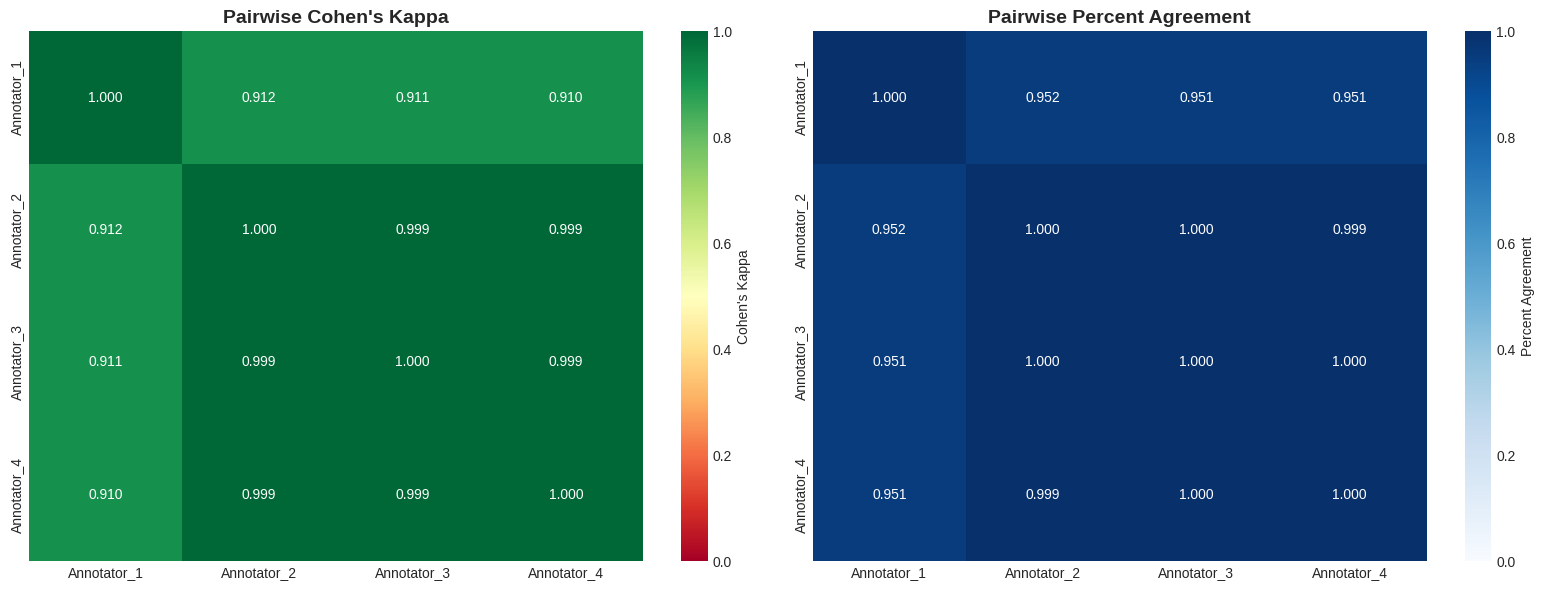

✓ Saved: iaa_heatmaps.png


In [63]:
# Create pairwise agreement heatmap
if len(pairwise_kappa_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Create matrices for heatmaps
    n_annotators = len(annotators)
    kappa_matrix = np.zeros((n_annotators, n_annotators))
    agreement_matrix = np.zeros((n_annotators, n_annotators))

    for _, row in pairwise_kappa_df.iterrows():
        i = annotators.index(row['Annotator_1'])
        j = annotators.index(row['Annotator_2'])
        kappa_matrix[i, j] = row['Cohen_Kappa']
        kappa_matrix[j, i] = row['Cohen_Kappa']
        agreement_matrix[i, j] = row['Percent_Agreement']
        agreement_matrix[j, i] = row['Percent_Agreement']

    # Set diagonal to 1.0
    np.fill_diagonal(kappa_matrix, 1.0)
    np.fill_diagonal(agreement_matrix, 1.0)

    # Plot Cohen's Kappa heatmap
    sns.heatmap(kappa_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
                xticklabels=annotators, yticklabels=annotators,
                vmin=0, vmax=1, ax=ax1, cbar_kws={'label': "Cohen's Kappa"})
    ax1.set_title("Pairwise Cohen's Kappa", fontsize=14, fontweight='bold')

    # Plot Percent Agreement heatmap
    sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=annotators, yticklabels=annotators,
                vmin=0, vmax=1, ax=ax2, cbar_kws={'label': 'Percent Agreement'})
    ax2.set_title('Pairwise Percent Agreement', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('iaa_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: iaa_heatmaps.png")


ANNOTATOR CONFUSION MATRICES (ALL PAIRS)

Processing Annotator_1 vs Annotator_2...


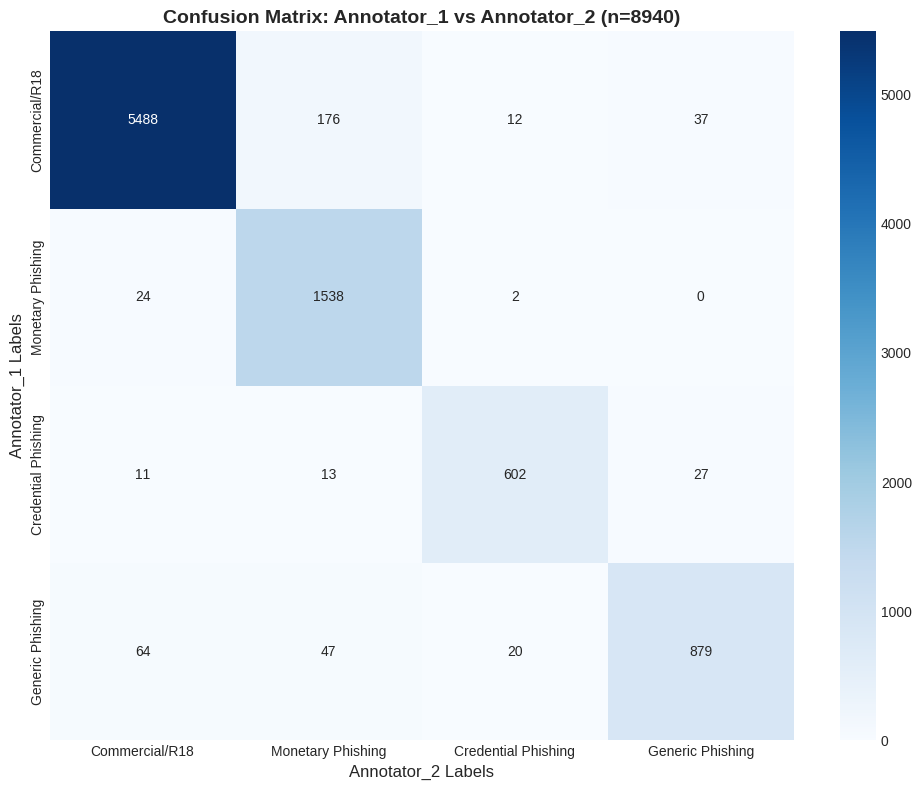

✓ Saved: confusion_Annotator_1_vs_Annotator_2.png

Processing Annotator_1 vs Annotator_3...


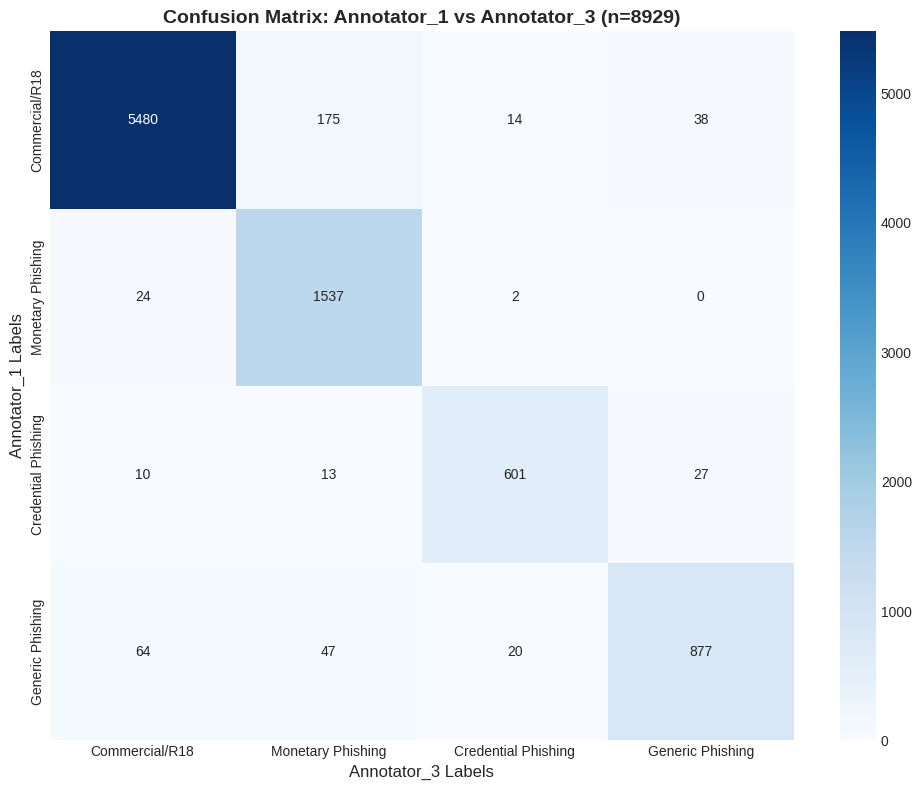

✓ Saved: confusion_Annotator_1_vs_Annotator_3.png

Processing Annotator_1 vs Annotator_4...


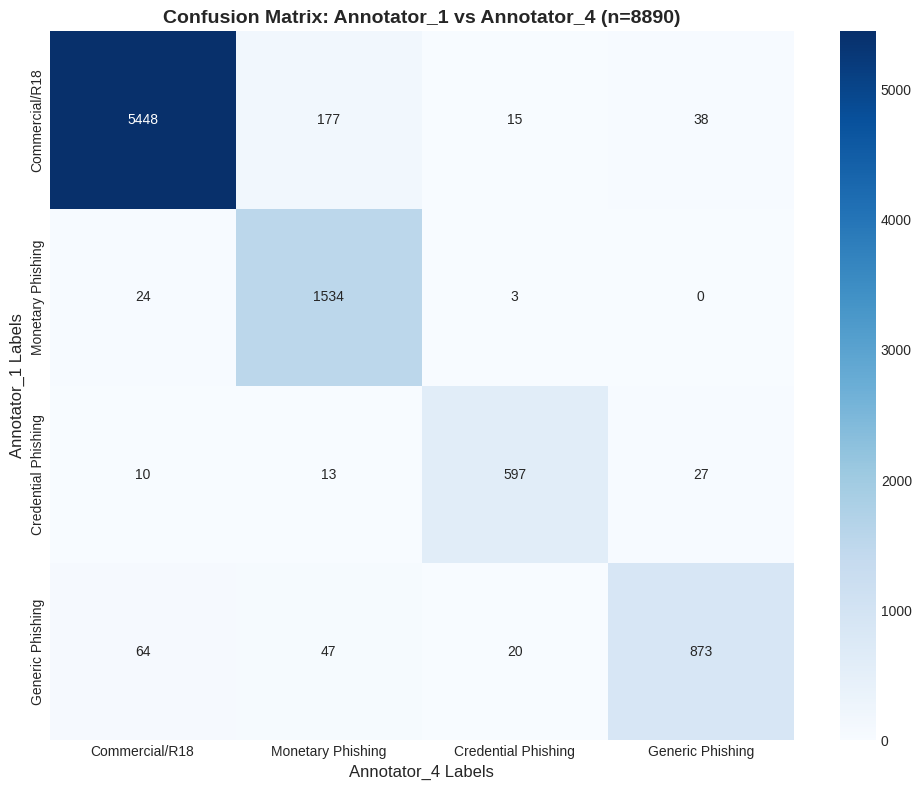

✓ Saved: confusion_Annotator_1_vs_Annotator_4.png

Processing Annotator_2 vs Annotator_3...


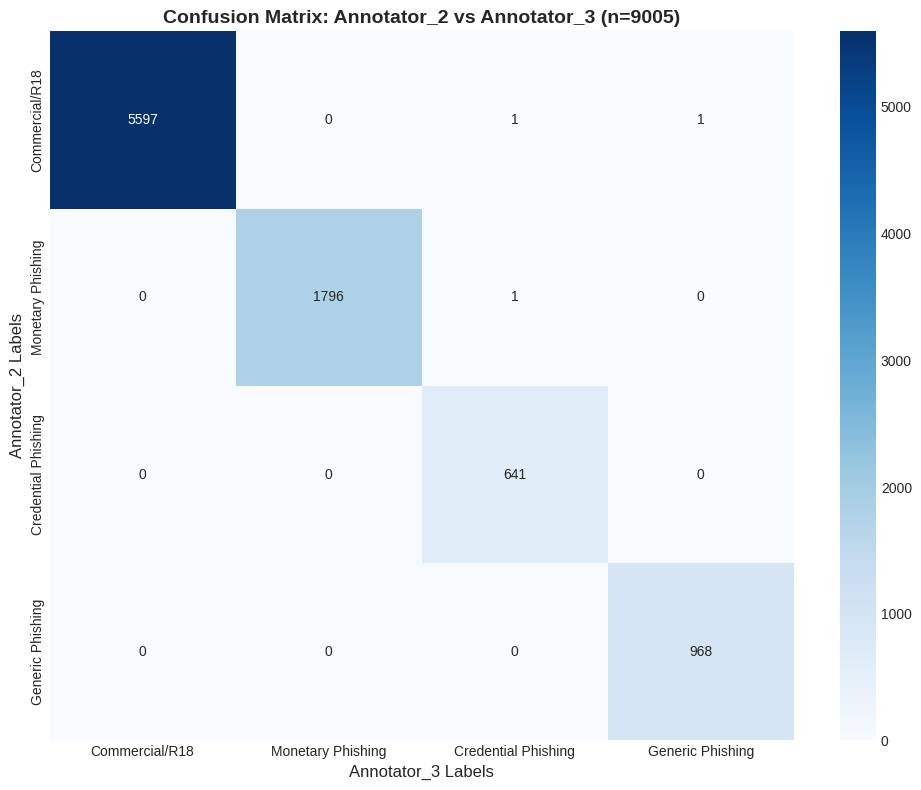

✓ Saved: confusion_Annotator_2_vs_Annotator_3.png

Processing Annotator_2 vs Annotator_4...


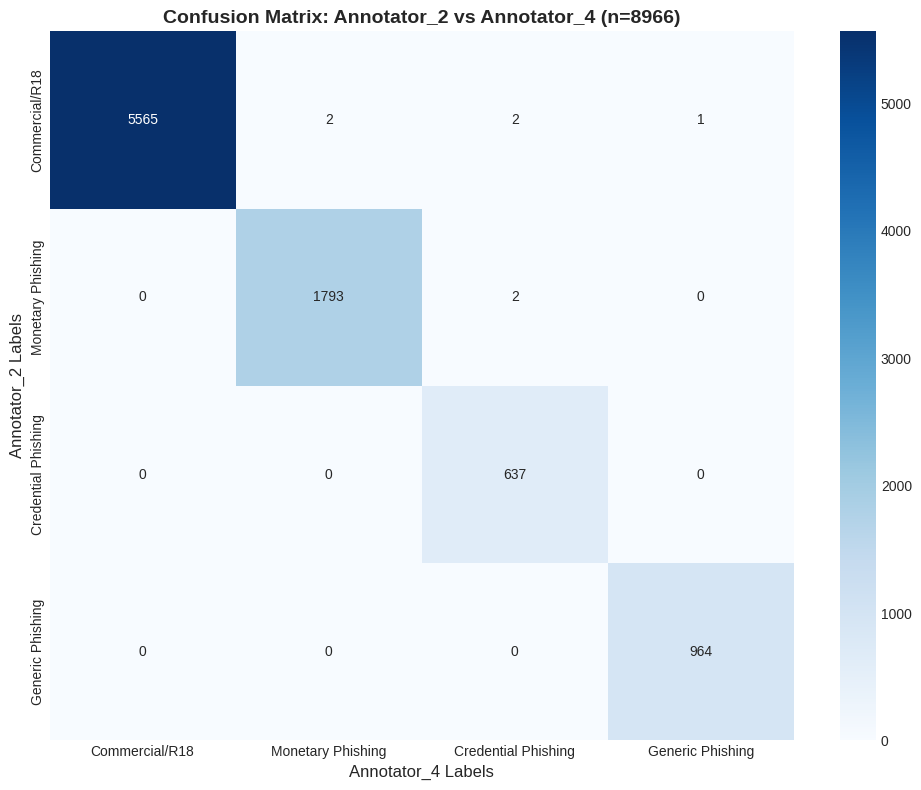

✓ Saved: confusion_Annotator_2_vs_Annotator_4.png

Processing Annotator_3 vs Annotator_4...


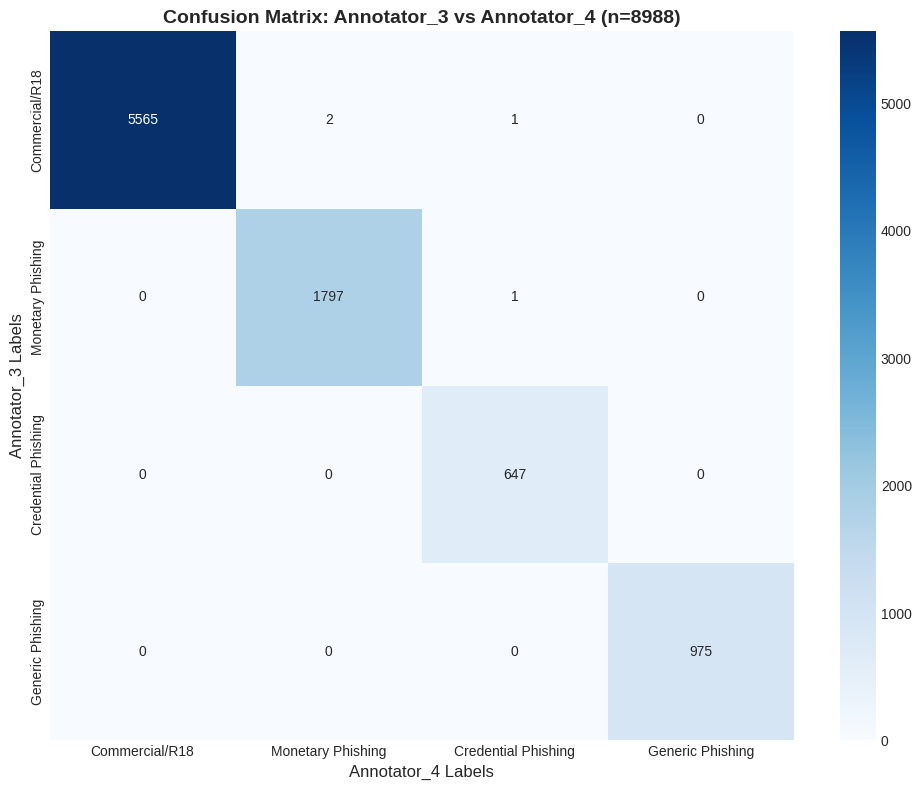

✓ Saved: confusion_Annotator_3_vs_Annotator_4.png


In [64]:
# Confusion matrices between annotators
def plot_annotator_confusion(combined_df, ann1, ann2):
    df1 = combined_df[combined_df['annotator'] == ann1][['text_cleaned', 'label']]
    df2 = combined_df[combined_df['annotator'] == ann2][['text_cleaned', 'label']]
    merged = df1.merge(df2, on='text_cleaned', suffixes=('_1', '_2'))

    if len(merged) > 0:
        # Ensure labels are integers for confusion_matrix
        y1 = merged['label_1'].astype(int)
        y2 = merged['label_2'].astype(int)

        cm = confusion_matrix(y1, y2,
                             labels=list(CLASS_LABELS.keys()))

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[CLASS_LABELS[i] for i in CLASS_LABELS.keys()],
                   yticklabels=[CLASS_LABELS[i] for i in CLASS_LABELS.keys()])
        plt.xlabel(f'{ann2} Labels', fontsize=12)
        plt.ylabel(f'{ann1} Labels', fontsize=12)
        plt.title(f'Confusion Matrix: {ann1} vs {ann2} (n={len(merged)})',
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        return cm
    return None

import itertools

# Plot confusion for all pairs
print("\n" + "="*80)
print("ANNOTATOR CONFUSION MATRICES (ALL PAIRS)")
print("="*80)

# Get all pairs of annotators
pairs = list(itertools.combinations(annotators, 2))

for ann1, ann2 in pairs:
    print(f"\nProcessing {ann1} vs {ann2}...")
    cm = plot_annotator_confusion(combined_df, ann1, ann2)
    if cm is not None:
        filename = f'confusion_{ann1}_vs_{ann2}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved: {filename}")

## 7. Weighted Voting - Tier 1 Resolution

Apply weighted majority voting to resolve disagreements automatically.

**Algorithm:**
1. For each email, sum weights for each class label
2. If one class has >50% of total weight → use that label
3. If tie (exactly 50-50 split) → flag for Tier 2 adjudication
4. If all annotators agree but with low confidence → flag for review

In [65]:
def apply_weighted_voting(row, annotator_weights, total_weight=5.0):
    """
    Apply weighted voting to resolve annotations.

    Returns:
        dict with keys:
        - consensus_label: Final label (or None if needs adjudication)
        - vote_weights: Dict of {label: total_weight}
        - winning_weight: Weight of winning label
        - needs_adjudication: Boolean
        - adjudication_reason: String explaining why
    """
    annotators = row['annotator']
    labels = row['label']
    confidences = row['confidence_numeric']

    # If only one annotator, use their label
    if len(annotators) == 1:
        return {
            'consensus_label': labels[0],
            'vote_weights': {labels[0]: annotator_weights[annotators[0]]},
            'winning_weight': annotator_weights[annotators[0]],
            'needs_adjudication': False,
            'adjudication_reason': ''
        }

    # Calculate weighted votes
    vote_weights = defaultdict(float)
    for ann, label in zip(annotators, labels):
        vote_weights[label] += annotator_weights[ann]

    # Find winning label
    sorted_votes = sorted(vote_weights.items(), key=lambda x: x[1], reverse=True)
    winning_label, winning_weight = sorted_votes[0]

    # Check for ties
    if len(sorted_votes) > 1 and sorted_votes[0][1] == sorted_votes[1][1]:
        # Exact tie - needs adjudication
        return {
            'consensus_label': None,
            'vote_weights': dict(vote_weights),
            'winning_weight': winning_weight,
            'needs_adjudication': True,
            'adjudication_reason': f'Tie: {sorted_votes[0][0]} and {sorted_votes[1][0]} both have {winning_weight:.1f} votes'
        }

    # Check if all annotators agree but with low confidence
    if len(set(labels)) == 1:  # All agree
        avg_confidence = np.mean(confidences)
        if avg_confidence < 1.5:  # All low confidence
            return {
                'consensus_label': winning_label,
                'vote_weights': dict(vote_weights),
                'winning_weight': winning_weight,
                'needs_adjudication': True,
                'adjudication_reason': f'Unanimous but low confidence (avg={avg_confidence:.2f})'
            }

    # Normal case - clear winner
    return {
        'consensus_label': winning_label,
        'vote_weights': dict(vote_weights),
        'winning_weight': winning_weight,
        'needs_adjudication': False,
        'adjudication_reason': ''
    }

# Apply weighted voting
print("\n" + "="*80)
print("APPLYING WEIGHTED VOTING (TIER 1)")
print("="*80)

voting_results = email_groups.apply(
    lambda row: apply_weighted_voting(row, ANNOTATOR_WEIGHTS),
    axis=1
)

# Extract results into columns
email_groups['consensus_label'] = voting_results.apply(lambda x: x['consensus_label'])
email_groups['vote_weights'] = voting_results.apply(lambda x: x['vote_weights'])
email_groups['winning_weight'] = voting_results.apply(lambda x: x['winning_weight'])
email_groups['needs_adjudication'] = voting_results.apply(lambda x: x['needs_adjudication'])
email_groups['adjudication_reason'] = voting_results.apply(lambda x: x['adjudication_reason'])

# Statistics
tier1_resolved = (~email_groups['needs_adjudication']).sum()
tier2_needed = email_groups['needs_adjudication'].sum()

print(f"\nTier 1 (Weighted Voting) Results:")
print(f"  Automatically resolved: {tier1_resolved} ({tier1_resolved/len(email_groups)*100:.1f}%)")
print(f"  Needs Tier 2 adjudication: {tier2_needed} ({tier2_needed/len(email_groups)*100:.1f}%)")


APPLYING WEIGHTED VOTING (TIER 1)

Tier 1 (Weighted Voting) Results:
  Automatically resolved: 9155 (100.0%)
  Needs Tier 2 adjudication: 1 (0.0%)


In [66]:
# Analyze adjudication reasons
if tier2_needed > 0:
    print("\n" + "="*80)
    print("TIER 2 ADJUDICATION NEEDED - BREAKDOWN")
    print("="*80)

    adjudication_df = email_groups[email_groups['needs_adjudication']].copy()

    # Categorize reasons
    reason_counts = adjudication_df['adjudication_reason'].value_counts()

    print("\nReasons for adjudication:")
    for reason, count in reason_counts.items():
        print(f"  {reason}: {count} emails")


TIER 2 ADJUDICATION NEEDED - BREAKDOWN

Reasons for adjudication:
  Tie: 3.0 and 1.0 both have 1.5 votes: 1 emails


## 8. Generate Final Consensus Labels

In [77]:
# Create consensus dataframe
consensus_df = email_groups[['text_cleaned', 'consensus_label', 'num_annotators',
                             'vote_weights', 'winning_weight', 'needs_adjudication',
                             'adjudication_reason']].copy()

# Add source dataset and other metadata from first annotation
# (assuming all annotations of same email have same metadata)
metadata_cols = ['source_dataset', 'text_length']
for col in metadata_cols:
    if col in combined_df.columns:
        metadata = combined_df.groupby('text_cleaned')[col].first()
        consensus_df = consensus_df.merge(
            metadata.reset_index(),
            on='text_cleaned',
            how='left'
        )

# Save consensus labels (excluding emails needing adjudication for now)
final_consensus = consensus_df[~consensus_df['needs_adjudication']].copy()

# For thesis presentation, rename columns
final_consensus_export = final_consensus[[
    'text_cleaned', 'consensus_label', 'num_annotators', 'winning_weight', 'source_dataset'
]].copy()
final_consensus_export.columns = ['text', 'label', 'num_annotators', 'vote_weight', 'source']

final_consensus_export.to_csv(OUTPUT_CONSENSUS, index=False)

print("\n" + "="*80)
print("CONSENSUS LABELS GENERATED")
print("="*80)
print(f"\nSaved: {OUTPUT_CONSENSUS}")
print(f"  Total emails with consensus: {len(final_consensus)}")
print(f"\nClass distribution in consensus:")
class_dist = final_consensus['consensus_label'].value_counts().sort_index()
for class_id, count in class_dist.items():
    class_name = CLASS_LABELS.get(class_id, f"Unknown_{class_id}")
    pct = (count / len(final_consensus)) * 100
    print(f"  {class_name}: {count} ({pct:.1f}%)")


CONSENSUS LABELS GENERATED

Saved: consensus_labels.csv
  Total emails with consensus: 9155

Class distribution in consensus:
  Commercial/R18: 5666 (61.9%)
  Monetary Phishing: 1831 (20.0%)
  Credential Phishing: 662 (7.2%)
  Generic Phishing: 996 (10.9%)


## 9. Export Emails Needing Adjudication (Tier 2)

In [68]:
if tier2_needed > 0:
    adjudication_export = consensus_df[consensus_df['needs_adjudication']].copy()

    # Add individual annotator labels for review
    adjudication_export['all_labels'] = email_groups[email_groups['needs_adjudication']]['label'].apply(
        lambda x: ', '.join([f"{CLASS_LABELS[lbl]}" for lbl in x])
    )
    adjudication_export['all_annotators'] = email_groups[email_groups['needs_adjudication']]['annotator'].apply(
        lambda x: ', '.join(x)
    )

    # Save for chief annotator
    adjudication_export[[
        'text_cleaned', 'all_annotators', 'all_labels', 'vote_weights',
        'adjudication_reason', 'source_dataset'
    ]].to_csv(OUTPUT_ADJUDICATION, index=False)

    print(f"\nSaved: {OUTPUT_ADJUDICATION}")
    print(f"  Emails needing manual adjudication: {len(adjudication_export)}")
    print(f"\n  Please review {OUTPUT_ADJUDICATION} and add 'final_label' column.")
else:
    print("\n✓ No emails need Tier 2 adjudication!")


Saved: adjudication_needed.csv
  Emails needing manual adjudication: 1

  Please review adjudication_needed.csv and add 'final_label' column.


## 10. Disagreement Analysis

Analyze patterns in annotator disagreements to identify difficult cases.

In [69]:
# Focus on emails with disagreements
disagreement_emails = overlapping_emails[overlapping_emails['num_annotators'] > 1].copy()
disagreement_emails['has_disagreement'] = disagreement_emails['label'].apply(
    lambda x: len(set(x)) > 1
)

disagreements = disagreement_emails[disagreement_emails['has_disagreement']].copy()

print("\n" + "="*80)
print("DISAGREEMENT ANALYSIS")
print("="*80)
print(f"\nEmails with 2+ annotators: {len(disagreement_emails)}")
print(f"  Perfect agreement: {(~disagreement_emails['has_disagreement']).sum()}")
print(f"  Has disagreement: {len(disagreements)}")
print(f"\nDisagreement rate: {len(disagreements)/len(disagreement_emails)*100:.1f}%")


DISAGREEMENT ANALYSIS

Emails with 2+ annotators: 9038
  Perfect agreement: 8599
  Has disagreement: 439

Disagreement rate: 4.9%


In [70]:
# Identify most confused class pairs
def extract_confusion_pairs(labels_list):
    """
    Extract pairs of labels that were confused.
    """
    pairs = []
    for labels in labels_list:
        if len(set(labels)) <= 1:  # No disagreement
            continue
        unique_labels = list(set(labels))
        for i, lbl1 in enumerate(unique_labels):
            for lbl2 in unique_labels[i+1:]:
                # Sort to avoid counting (1,2) and (2,1) separately
                pair = tuple(sorted([lbl1, lbl2]))
                pairs.append(pair)
    return pairs

confusion_pairs = extract_confusion_pairs(disagreements['label'].tolist())
pair_counts = Counter(confusion_pairs)

print("\nMost common class confusions:")
for (class1, class2), count in pair_counts.most_common(10):
    name1 = CLASS_LABELS.get(class1, f"Unknown_{class1}")
    name2 = CLASS_LABELS.get(class2, f"Unknown_{class2}")
    print(f"  {name1} ↔ {name2}: {count} instances")


Most common class confusions:
  Commercial/R18 ↔ Monetary Phishing: 202 instances
  Commercial/R18 ↔ Generic Phishing: 102 instances
  Credential Phishing ↔ Generic Phishing: 47 instances
  Monetary Phishing ↔ Generic Phishing: 47 instances
  Commercial/R18 ↔ Credential Phishing: 26 instances
  Monetary Phishing ↔ Credential Phishing: 17 instances


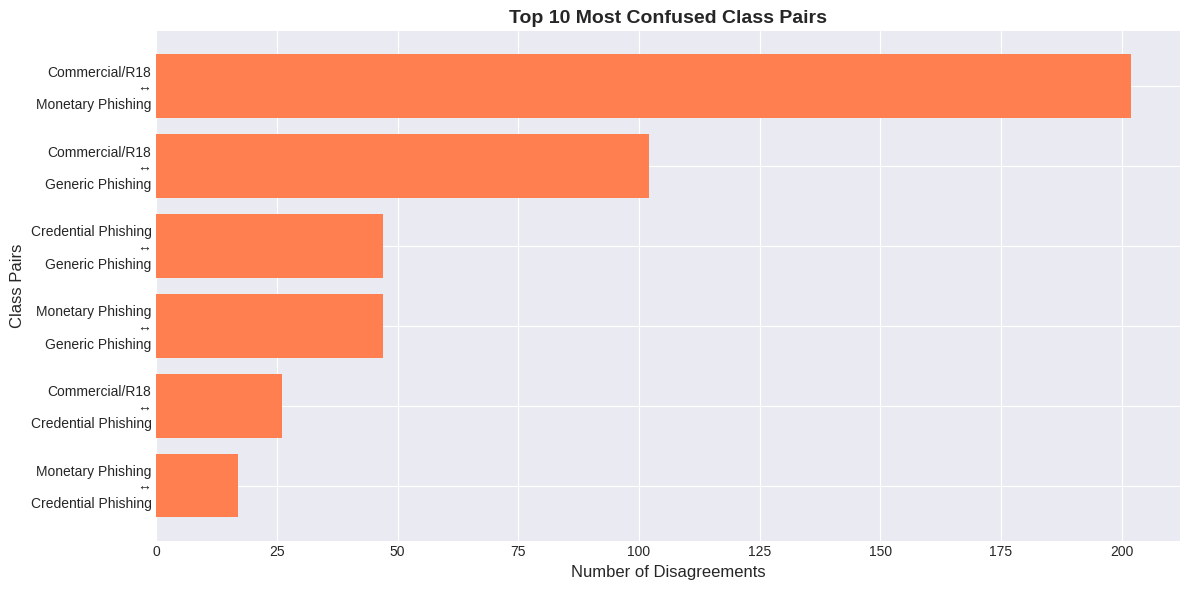

✓ Saved: class_confusion_pairs.png


In [71]:
# Visualize confusion pairs
if len(pair_counts) > 0:
    top_pairs = pair_counts.most_common(10)
    pair_labels = [f"{CLASS_LABELS[p[0]]}\n↔\n{CLASS_LABELS[p[1]]}" for p, _ in top_pairs]
    pair_values = [count for _, count in top_pairs]

    plt.figure(figsize=(12, 6))
    plt.barh(pair_labels, pair_values, color='coral')
    plt.xlabel('Number of Disagreements', fontsize=12)
    plt.ylabel('Class Pairs', fontsize=12)
    plt.title('Top 10 Most Confused Class Pairs', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('class_confusion_pairs.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Saved: class_confusion_pairs.png")

## 11. Generate IAA Summary Report

In [72]:
# Create comprehensive IAA report
iaa_report = {
    'Metric': [
        'Total Unique Emails',
        'Emails with Multiple Annotators',
        'Percent Agreement',
        "Fleiss' Kappa",
        "Krippendorff's Alpha",
        "Average Pairwise Cohen's Kappa",
        'Emails Automatically Resolved (Tier 1)',
        'Emails Needing Adjudication (Tier 2)',
        'Disagreement Rate (Multi-Annotator Emails)'
    ],
    'Value': [
        len(email_groups),
        len(overlapping_emails),
        f"{percent_agreement:.3f}",
        f"{fleiss_k:.3f}" if fleiss_k is not None else 'N/A',
        f"{kripp_alpha:.3f}" if kripp_alpha is not None else 'N/A',
        f"{avg_kappa:.3f}" if len(pairwise_kappa_df) > 0 else 'N/A',
        tier1_resolved,
        tier2_needed,
        f"{len(disagreements)/len(disagreement_emails)*100:.1f}%" if len(disagreement_emails) > 0 else 'N/A'
    ]
}

iaa_report_df = pd.DataFrame(iaa_report)
iaa_report_df.to_csv(OUTPUT_IAA_REPORT, index=False)

print("\n" + "="*80)
print("IAA SUMMARY REPORT")
print("="*80)
print(iaa_report_df.to_string(index=False))
print(f"\n✓ Saved: {OUTPUT_IAA_REPORT}")


IAA SUMMARY REPORT
                                    Metric Value
                       Total Unique Emails  9156
           Emails with Multiple Annotators  9038
                         Percent Agreement 0.988
                             Fleiss' Kappa 0.955
                      Krippendorff's Alpha 0.956
            Average Pairwise Cohen's Kappa 0.955
    Emails Automatically Resolved (Tier 1)  9155
      Emails Needing Adjudication (Tier 2)     1
Disagreement Rate (Multi-Annotator Emails)  4.9%

✓ Saved: iaa_report.csv


## 12. Export Disagreement Analysis

In [73]:
# Save detailed disagreement analysis
if len(disagreements) > 0:
    disagreement_analysis = []

    for _, row in disagreements.iterrows():
        labels = row['label']
        annotators = row['annotator']

        disagreement_analysis.append({
            'text_sample': row['text_cleaned'][:200] + '...',  # First 200 chars
            'num_annotators': len(annotators),
            'unique_labels': len(set(labels)),
            'labels': ', '.join([CLASS_LABELS[lbl] for lbl in labels]),
            'annotators': ', '.join(annotators)
        })

    disagreement_df = pd.DataFrame(disagreement_analysis)
    disagreement_df.to_csv(OUTPUT_DISAGREEMENTS, index=False)

    print(f"✓ Saved: {OUTPUT_DISAGREEMENTS}")
    print(f"  Contains {len(disagreement_df)} disagreement cases for analysis")

✓ Saved: disagreement_analysis.csv
  Contains 439 disagreement cases for analysis


## 13. Final Summary and Next Steps

In [74]:
print("\n" + "="*80)
print("CONSENSUS RESOLUTION COMPLETE")
print("="*80)

print("\n📁 Output Files Generated:")
print(f"  1. {OUTPUT_CONSENSUS}")
print(f"     → {len(final_consensus)} emails with consensus labels")
print(f"     → Ready for model training")

print(f"\n  2. {OUTPUT_IAA_REPORT}")
print(f"     → Inter-annotator agreement metrics")
print(f"     → Include in thesis Chapter 4 (Methodology)")

if tier2_needed > 0:
    print(f"\n  3. {OUTPUT_ADJUDICATION}")
    print(f"     → {tier2_needed} emails needing manual review")
    print(f"     → Chief annotator should add 'final_label' column")

if len(disagreements) > 0:
    print(f"\n  4. {OUTPUT_DISAGREEMENTS}")
    print(f"     → {len(disagreements)} disagreement cases")
    print(f"     → For error analysis in thesis")

print(f"\n  5. Visualizations:")
print(f"     → iaa_heatmaps.png")
print(f"     → confusion_expert_vs_expert.png")
print(f"     → class_confusion_pairs.png")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

if tier2_needed > 0:
    print(f"\n⚠️  ACTION REQUIRED:")
    print(f"  1. Chief annotator must review {OUTPUT_ADJUDICATION}")
    print(f"  2. Add 'final_label' column with adjudicated labels")
    print(f"  3. Merge adjudicated labels back into {OUTPUT_CONSENSUS}")
    print(f"  4. Then proceed to training notebook")
else:
    print(f"\n✓ All annotations resolved automatically!")
    print(f"  Proceed directly to training notebook (2_Training.ipynb)")

print("\n📊 For Thesis Documentation:")
print(f"  • Report IAA metrics from {OUTPUT_IAA_REPORT}")
print(f"  • Include Fleiss' Kappa: {fleiss_k:.3f}" if fleiss_k else "  • Include Fleiss' Kappa: N/A")
print(f"  • Discuss disagreement patterns from confusion analysis")
print(f"  • Describe weighted voting methodology")

print("\n" + "="*80)


CONSENSUS RESOLUTION COMPLETE

📁 Output Files Generated:
  1. consensus_labels.csv
     → 9155 emails with consensus labels
     → Ready for model training

  2. iaa_report.csv
     → Inter-annotator agreement metrics
     → Include in thesis Chapter 4 (Methodology)

  3. adjudication_needed.csv
     → 1 emails needing manual review
     → Chief annotator should add 'final_label' column

  4. disagreement_analysis.csv
     → 439 disagreement cases
     → For error analysis in thesis

  5. Visualizations:
     → iaa_heatmaps.png
     → confusion_expert_vs_expert.png
     → class_confusion_pairs.png

NEXT STEPS

⚠️  ACTION REQUIRED:
  1. Chief annotator must review adjudication_needed.csv
  2. Add 'final_label' column with adjudicated labels
  3. Merge adjudicated labels back into consensus_labels.csv
  4. Then proceed to training notebook

📊 For Thesis Documentation:
  • Report IAA metrics from iaa_report.csv
  • Include Fleiss' Kappa: 0.955
  • Discuss disagreement patterns from confu

## 14. Merge Adjudicated Labels

Run this cell **after** you have:
1. Downloaded `adjudication_needed.csv`
2. Added a column named `final_label`
3. Filled in the correct class (1, 2, 3, or 4) for each row
4. Re-uploaded the file to Colab (overwriting the old one)

In [76]:
try:
    # 1. Load the adjudicated file (from external tool)
    adjudicated_file = 'adjudicated_labels.csv'
    adjudicated_df = pd.read_csv(adjudicated_file)

    # 2. Load the original request file to retrieve text and metadata
    # (Because the adjudicator output seems to lack 'text_cleaned')
    original_file = OUTPUT_ADJUDICATION  # 'adjudication_needed.csv'
    original_df = pd.read_csv(original_file)

    print(f"Loaded {len(adjudicated_df)} decisions from {adjudicated_file}")
    print(f"Loaded {len(original_df)} original cases from {original_file}")

    # 3. Merge decisions back to original data
    # Check if 'text_cleaned' exists; if not, map by row order or ID
    if 'text_cleaned' not in adjudicated_df.columns:
        print("Note: 'text_cleaned' missing in adjudicated file. Mapping by ID/Index.")

        # If email_id exists, use it to map to the index of the original file
        if 'email_id' in adjudicated_df.columns:
            # Create a mapping from ID to label
            # Assuming email_id corresponds to the dataframe index of the original file
            label_map = adjudicated_df.set_index('email_id')['final_label']
            original_df['final_label'] = original_df.index.map(label_map)
        else:
            # Fallback: Assume strict row order if counts match
            if len(adjudicated_df) == len(original_df):
                original_df['final_label'] = adjudicated_df['final_label']
            else:
                print("⚠️ Cannot automatically map rows: Row counts differ and no ID column found.")
    else:
        # If text exists in adjudicated file, just use it
        original_df = adjudicated_df

    # 4. Process Resolved Cases
    if 'final_label' in original_df.columns:
        # Filter for rows that have a final label (not empty)
        resolved_cases = original_df[original_df['final_label'].notna()].copy()

        print(f"Found {len(resolved_cases)} resolved adjudication cases.")

        if len(resolved_cases) > 0:
            # 5. Prepare format to match consensus_labels.csv
            resolved_export = pd.DataFrame()
            resolved_export['text'] = resolved_cases['text_cleaned']
            resolved_export['label'] = resolved_cases['final_label']

            # Calculate num_annotators from the 'all_annotators' string
            resolved_export['num_annotators'] = resolved_cases['all_annotators'].apply(
                lambda x: len(str(x).split(', '))
            )

            # Set weight to 5.0 (max) to indicate manual authority
            resolved_export['vote_weight'] = 5.0

            resolved_export['source'] = resolved_cases['source_dataset']

            # 6. Load existing consensus file
            existing_consensus = pd.read_csv(OUTPUT_CONSENSUS)

            # 7. Append and Save
            updated_consensus = pd.concat([existing_consensus, resolved_export], ignore_index=True)
            updated_consensus.to_csv(OUTPUT_CONSENSUS, index=False)

            print(f"✓ Merged {len(resolved_export)} adjudicated cases into {OUTPUT_CONSENSUS}")
            print(f"  Previous total: {len(existing_consensus)}")
            print(f"  New total: {len(updated_consensus)}")

            # Update the global dataframe variable too if needed
            final_consensus_export = updated_consensus

        else:
            print("No resolved cases found (rows with 'final_label' are empty).")
    else:
        print(f"⚠️ Column 'final_label' not found. Please check {adjudicated_file}.")

except FileNotFoundError as e:
    print(f"❌ File not found: {e.filename}. Please ensure both {OUTPUT_ADJUDICATION} and {adjudicated_file} exist.")
except Exception as e:
    print(f"❌ An error occurred: {str(e)}")

Loaded 1 decisions from adjudicated_labels.csv
Loaded 1 original cases from adjudication_needed.csv
Note: 'text_cleaned' missing in adjudicated file. Mapping by ID/Index.
Found 1 resolved adjudication cases.
✓ Merged 1 adjudicated cases into consensus_labels.csv
  Previous total: 9155
  New total: 9156


In [78]:
import zipfile
import os
import glob

# Define output zip filename
zip_filename = 'annotation_analysis_results.zip'

# List of specific files to include
files_to_zip = [
    OUTPUT_CONSENSUS,
    OUTPUT_IAA_REPORT,
    OUTPUT_ADJUDICATION,
    OUTPUT_DISAGREEMENTS,
    'iaa_heatmaps.png',
    'class_confusion_pairs.png'
]

# Add all confusion matrix plots dynamically
confusion_plots = glob.glob('confusion_*.png')
files_to_zip.extend(confusion_plots)

print(f"Creating archive: {zip_filename}...")

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f"  + Added: {file}")
        else:
            print(f"  - Warning: File not found (skipped): {file}")

print(f"\n✓ All findings archived in {zip_filename}")
print("  You can download this file from the file explorer on the left.")

Creating archive: annotation_analysis_results.zip...
  + Added: consensus_labels.csv
  + Added: iaa_report.csv
  + Added: adjudication_needed.csv
  + Added: disagreement_analysis.csv
  + Added: iaa_heatmaps.png
  + Added: class_confusion_pairs.png
  + Added: confusion_Annotator_3_vs_Annotator_4.png
  + Added: confusion_Annotator_1_vs_Annotator_3.png
  + Added: confusion_Annotator_1_vs_Annotator_4.png
  + Added: confusion_Annotator_2_vs_Annotator_3.png
  + Added: confusion_Annotator_1_vs_Annotator_2.png
  + Added: confusion_Annotator_2_vs_Annotator_4.png
  + Added: confusion_expert_vs_expert.png

✓ All findings archived in annotation_analysis_results.zip
  You can download this file from the file explorer on the left.
